In [15]:
Alpha_Name = "5_Input_20220111_10d_norm_ret"
start_date = "2020-01-01"
end_date = "2020-06-01"

In [16]:
import time
import os
from Research.backtest.bt import BTDaily
import matplotlib.pyplot as plt
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
from Platform.database.mysql import MysqlAPI
from Platform.utils.persistence import convert_to_standard_daily_feature_csv, convert_to_standard_daily_feature_par
from Platform.config.mysql_info import FACTOR_LIB_MYSQL_TIO
import DataAPI
from os import walk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import multiprocessing as mp
import sys
sys.path.append("/home/wuwenjun/jupyter_code/Shannon/AlphaNet/packages/")
model_path = "/home/wuwenjun/Alpha_Factor/" + Alpha_Name + "/" + "%s_%s" %(start_date,end_date) + "/"
if os.path.exists(model_path) == False:
    os.makedirs(model_path)
    print(model_path)

In [17]:
from AlphaNet.Data import DataLoader
trainloader = DataLoader()
trainloader.load_data_from_file(alpha_name = Alpha_Name,end_date = start_date)

100%|██████████| 1219/1219 [00:22<00:00, 54.51it/s]


0         1            2         3  \
timestamp           ticker                                              
2015-02-16 09:30:00 000001  0.000064 -0.038558  3954.352065 -0.014480   
                    000002  0.000147  0.135621  5523.931352 -0.033847   
                    000004  0.000093 -0.003361   -18.869629 -0.019579   
                    000006  0.000035  0.054798  2741.562408 -0.009933   
                    000007  0.000016  0.000012     8.076373 -0.003366   
...                              ...       ...          ...       ...   
2019-12-31 09:30:00 688168  0.000066 -0.012922    23.137283 -0.020336   
                    688188  0.000054 -0.021006    23.665992 -0.019726   
                    688321  0.000258 -0.057467   632.000022 -0.182739   
                    688333  0.000022 -0.002794    46.470611 -0.035519   
                    688388  0.000037 -0.001228    78.998641 -0.007192   

                                   4             5         6             7  \
timestamp           ticker                                                   
2015-02-16 09:30:00 000001 -0.153531  -2626.705689 -0.017612  1.415203e+07   
                    000002 -0.583065 -11505.304621 -0.048414  8.801691e+07   
                    000004 -0.011733   -121.588925 -0.039625  6.284071e+03   
                    000006  0.008375    430.094542 -0.002161  1.746874e+06   
                    000007 -0.005832    -66.787909 -0.016842  2.674150e+03   
...                              ...           ...       ...           ...   
2019-12-31 09:30:00 688168 -0.014921    -23.111938 -0.032362  3.088676e+03   
                    688188 -0.044288   -119.499083 -0.059382  1.449335e+04   
                    688321 -0.021098     14.934420 -0.029917  2.274249e+03   
                    688333  0.005928     -0.395460 -0.006051  3.237477e+03   
                    688388 -0.003517    -91.809291 -0.025993  3.661133e+03   

                                     8             9  ...       111       112  \
timestamp           ticker                            ...                       
2015-02-16 09:30:00 000001   13.814661  1.150742e+05  ...  0.345175  0.023481   
                    000002  121.464693  2.913541e+06  ...  0.085346 -0.009313   
                    000004    1.512995  1.306707e+04  ...  0.081493  0.038451   
                    000006    0.897457 -3.758064e+04  ...  0.088571  0.000000   
                    000007    1.296660  7.027719e+03  ...  0.627692 -0.137272   
...                                ...           ...  ...       ...       ...   
2019-12-31 09:30:00 688168    3.398853  3.348954e+03  ...  0.725095  0.029854   
                    688188    7.882333  1.672978e+04  ...  0.913885  0.085187   
                    688321    8.225609 -4.851141e+04  ...  0.533274 -0.045798   
                    688333   -0.715351 -5.582266e+03  ... -0.686561 -0.024109   
                    688388    1.455787  1.702078e+04  ...  4.525981  0.209164   

                                 113       114       115       116  \
timestamp           ticker                                           
2015-02-16 09:30:00 000001  0.031142 -1.301542  0.014472 -0.012360   
                    000002 -0.004410 -2.271306  0.020087 -0.022228   
                    000004 -0.009981 -1.736879  0.011924 -0.014008   
                    000006  0.060849 -2.261014  0.013070 -0.012106   
                    000007  2.823077  7.882863  0.016853 -0.018813   
...                              ...       ...       ...       ...   
2019-12-31 09:30:00 688168 -0.086762 -0.841671  0.022664 -0.022942   
                    688188 -0.189385 -1.574561  0.018257 -0.025162   
                    688321 -0.217366 -0.163770  0.023363 -0.015684   
                    688333 -0.619115 -1.278914  0.022043 -0.016796   
                    688388  0.212289  4.499188  0.026055 -0.035712   

                                    117           118       119    target  
timestamp           ticker   

In [18]:
train_loader = trainloader.to_torch_DataLoader(sequence = 3,shuffle=True)
trainloader.shape

torch.Size([3439333, 3, 40])

In [19]:
from AlphaNet.Models import AlphaNet_LSTM_V1
from AlphaNet import Model_Loader
import torch.optim as optim
LR = 0.001
epoch_num = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_function = nn.MSELoss()
model = AlphaNet_LSTM_V1(40, 64)
optimizer = optim.Adam(model.parameters(), lr=LR)
model_loader = Model_Loader(model = model,device=device)
print(model_loader.model)

AlphaNet_LSTM_V1(
  (batch): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 64, num_layers=5, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Learning Rate is : 0.001


 10%|█         | 1/10 [00:44<06:38, 44.26s/it]

Epoch:  1  loss:  0.00955434164845205


 20%|██        | 2/10 [01:28<05:53, 44.14s/it]

Epoch:  2  loss:  0.008620159450707019


 30%|███       | 3/10 [02:12<05:09, 44.22s/it]

Epoch:  3  loss:  0.008224241622567142


 40%|████      | 4/10 [02:55<04:23, 43.87s/it]

Epoch:  4  loss:  0.007941482078915629


 50%|█████     | 5/10 [03:42<03:43, 44.78s/it]

Epoch:  5  loss:  0.007725058087113108


 60%|██████    | 6/10 [04:27<02:59, 44.84s/it]

Epoch:  6  loss:  0.0075427159460425


 70%|███████   | 7/10 [05:08<02:11, 43.75s/it]

Epoch:  7  loss:  0.007387487036503117


 80%|████████  | 8/10 [05:51<01:26, 43.33s/it]

Epoch:  8  loss:  0.007258342172076189


 90%|█████████ | 9/10 [06:32<00:42, 42.79s/it]

Epoch:  9  loss:  0.007135594562099913


100%|██████████| 10/10 [07:16<00:00, 43.68s/it]

Epoch:  10  loss:  0.007026977607119249


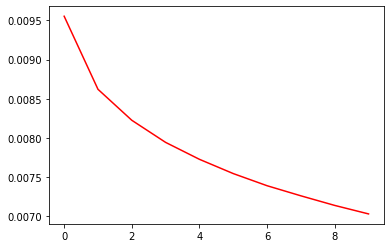

In [20]:
model = model_loader.fit_transform(train_loader,optimizer,loss_function,epoch_num,save_path = model_path)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=LR/10)
model = model_loader.transform(optimizer = optimizer, epoch_num = 30, method="best")

  0%|          | 0/30 [00:00<?, ?it/s]

Learning Rate is : 0.0001


  3%|▎         | 1/30 [00:50<24:33, 50.83s/it]

Epoch:  1  loss:  0.5197009948004345


  7%|▋         | 2/30 [01:37<22:36, 48.43s/it]

Epoch:  2  loss:  0.5146741433210091


 10%|█         | 3/30 [02:27<22:07, 49.16s/it]

Epoch:  3  loss:  0.5127578748768826


 13%|█▎        | 4/30 [03:14<20:59, 48.46s/it]

Epoch:  4  loss:  0.5117522480515997


 17%|█▋        | 5/30 [04:11<21:27, 51.50s/it]

Epoch:  5  loss:  0.510751719617665


 20%|██        | 6/30 [05:00<20:13, 50.55s/it]

Epoch:  6  loss:  0.5098746088821193


 23%|██▎       | 7/30 [05:55<19:58, 52.13s/it]

Epoch:  7  loss:  0.5093930924652932


 27%|██▋       | 8/30 [06:43<18:35, 50.68s/it]

Epoch:  8  loss:  0.5087727180862948


 30%|███       | 9/30 [07:43<18:46, 53.62s/it]

Epoch:  9  loss:  0.5083340887346531


 33%|███▎      | 10/30 [08:37<17:54, 53.73s/it]

Epoch:  10  loss:  0.5079743043528943


 37%|███▋      | 11/30 [09:30<16:55, 53.44s/it]

Epoch:  11  loss:  0.50713708002287


 40%|████      | 12/30 [10:14<15:13, 50.73s/it]

Epoch:  12  loss:  0.5067810822517591


 43%|████▎     | 13/30 [11:03<14:12, 50.12s/it]

Epoch:  13  loss:  0.5063884140943318


 47%|████▋     | 14/30 [11:49<13:00, 48.77s/it]

Epoch:  14  loss:  0.5060762608295444


 50%|█████     | 15/30 [12:33<11:50, 47.36s/it]

Epoch:  15  loss:  0.5055116610184972


 53%|█████▎    | 16/30 [13:17<10:49, 46.41s/it]

Epoch:  16  loss:  0.5053731308427277


 57%|█████▋    | 17/30 [14:02<09:57, 45.97s/it]

Epoch:  17  loss:  0.5050073120205361


 60%|██████    | 18/30 [14:46<09:05, 45.49s/it]

Epoch:  18  loss:  0.5044079321942236


 63%|██████▎   | 19/30 [15:33<08:24, 45.86s/it]

Epoch:  19  loss:  0.5042024213583725


 67%|██████▋   | 20/30 [16:19<07:38, 45.90s/it]

Epoch:  20  loss:  0.5035885211989592


 70%|███████   | 21/30 [17:04<06:51, 45.69s/it]

Epoch:  21  loss:  0.5035206426835733


 70%|███████   | 21/30 [17:35<07:32, 50.26s/it]


KeyboardInterrupt: 

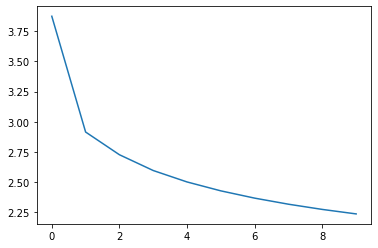

In [7]:
plt.plot(model_loader.loss_list)

In [21]:
testloader = DataLoader()
testloader.load_data_from_file(alpha_name = Alpha_Name,start_date = start_date,end_date = end_date)
test_loader = testloader.to_torch_DataLoader(sequence = 3,shuffle=False)
pred = model_loader.pred(test_loader)

100%|██████████| 98/98 [00:02<00:00, 47.69it/s]


In [22]:
final = pd.concat([testloader.target.reset_index(),pred],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
final

,timestamp,symbol,target,5_Input_20220111_10d_norm_ret
0,2020-01-02 09:30:00,000001,-0.007808,0.006008
1,2020-01-02 09:30:00,000002,-0.066463,0.023818
2,2020-01-02 09:30:00,000004,0.007064,-0.002436
3,2020-01-02 09:30:00,000005,0.025723,-0.012045
4,2020-01-02 09:30:00,000006,0.007366,-0.014588
...,...,...,...,...
350863,2020-06-01 09:30:00,688388,-0.034015,-0.011107
350864,2020-06-01 09:30:00,688389,0.020294,-0.017103
350865,2020-06-01 09:30:00,688396,-0.000301,-0.031794
350866,2020-06-01 09:30:00,688398,-0.034310,0.042025


In [23]:
final.to_parquet(model_path + "result.par")